# Import Library

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io  # Using scikit-image to read image
from enum import Enum
import os


# Configuration

In [15]:
class ImageType(Enum):
    Carambula = 0
    Lychee = 1
    Pear = 2


class Config(Enum):
    num_component = 2
    size_2layer = [16, 32, 64, 128]
    size_3layer = [[8, 4], [16, 8], [32, 16], [36, 20]]
    random_seed = 100
    learning_rate_2layer = 0.02
    learning_rate_3layer = 0.018
    epoch = 1024
    batch_size = 1
    alpha = 1


def rng_generator():
    return np.random.default_rng(Config.random_seed.value)


# Read image & reduce dimension

In [16]:
class ImageLoader:
    def __init__(self, dir, split) -> None:
        self.split = split
        self.dir = os.path.join(
            dir, "Data_train" if split == "train" else "Data_test"
        )

        self.images = []
        self.labels = []

        for index in ImageType:
            images_path = os.path.join(self.dir, index.name, "*.png")
            images = io.imread_collection(images_path).concatenate() / 255

            self.images.extend(images)
            self.labels.extend([index.value for _ in images])

        self.images_pca = self.__get_PCA_images()
        x, y = np.split(self.images_pca, 2, 1)
        norm_x, norm_y = self.normalize(x), self.normalize(y)
        self.images = np.stack((norm_x, norm_y), 1).reshape(
            -1, Config.num_component.value
        )

    def __get_PCA_images(self):
        self.images_reshape = [image.flatten() for image in self.images]

        if self.split == "train":
            return pca.fit_transform(self.images_reshape)
        else:
            return pca.transform(self.images_reshape)

    def normalize(self, x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    def get(self):
        return self.images, np.array(self.labels)


In [17]:
pca = PCA(n_components=Config.num_component.value)

train_x, train_y = ImageLoader(".", "train").get()
test_x, test_y = ImageLoader(".", "test").get()


# Activation & Utility function

In [18]:
class Activation:
    def ReLU(self, x):
        return np.maximum(0, x)

    def ReLU_derivative(self, x):
        return (x > 0) * 1

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - self.tanh(x) ** 2

    def ELU(self, x):
        return (x > 0) * x + (x <= 0) * Config.alpha.value * (np.exp(x) - 1)

    def ELU_derivative(self, x):
        return (x >= 0) * 1 + (x < 0) * Config.alpha.value * np.exp(x)

    def get(self, func_type: str):
        if func_type == "sigmoid":
            return self.sigmoid, self.sigmoid_derivative

        elif func_type == "ReLU":
            return self.ReLU, self.ReLU_derivative

        elif func_type == "tanh":
            return self.tanh, self.tanh_derivative

        elif func_type == "ELU":
            return self.ELU, self.ELU_derivative


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)


In [19]:
def plot_loss_curve(epoch_loss, title):
    plt.plot(range(len(epoch_loss)), epoch_loss)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


# Evaluate the accuracy
def evaluate(pred_y, test_y):
    corr = [(pred == test) for pred, test in zip(pred_y, test_y)]
    return np.mean(corr)


# NN Model

In [20]:
class NN:
    def __init__(self, size: list, activation_type="sigmoid") -> None:
        self.size = size
        self.num_layer = len(size)

        # Initialize bias with random float matrix (i: # node of layer i)
        self.bias = [rng.random((i, 1)) for i in size[1:]]

        # Initialize weight with random float matrix (k, j: # node of layer k, j)
        self.weights = [rng.random((j, k)) for k, j in zip(size[:-1], size[1:])]

        # Input activation function according to input type
        self.acti_func, self.acti_derivative = Activation.get(
            Activation(), activation_type
        )

    # For the cost differential by output activation
    def cost_derivative(self, label, pred):
        pred[label] -= 1
        return pred

    # Cross entropy
    def loss_func(self, label, pred):
        return -np.log(pred[label])

    def shuffle_data(self, features, labels):
        combine = list(zip(features, labels))
        rng.shuffle(combine)
        return zip(*combine)

    def to2d(self, feature: np.ndarray):
        return feature.reshape(-1, 1)

    def random_split_batch(self, features, labels, batch_size):
        features, labels = self.shuffle_data(features, labels)

        split_point = np.arange(batch_size, len(features), batch_size)
        batch_features = np.split(np.array(features), split_point)
        batch_labels = np.split(np.array(labels), split_point)
        return batch_features, batch_labels

    def feed_forward(self, feature: np.ndarray) -> np.ndarray:
        # Initial declare the variable
        activation = feature
        activations = [activation]
        zs = []

        # Hidden layer
        for b, w in zip(self.bias, self.weights):
            z = np.dot(w, activation) + b
            activation = self.acti_func(z)

            zs.append(z)
            activations.append(activation)

        # Output layer
        activations[-1] = softmax(activations[-1])

        return zs, activations

    def back_propagation(self, feature, label):
        zs, activations = self.feed_forward(feature)

        weight_gradient = [np.zeros(w.shape) for w in self.weights]
        bias_gradient = [np.zeros(b.shape) for b in self.bias]

        # Output layer gradient calculate
        sensitivity = self.cost_derivative(
            label, activations[-1].copy()
        ) * self.acti_derivative(zs[-1])

        bias_gradient[-1] = sensitivity
        weight_gradient[-1] = np.dot(sensitivity, activations[-2].T)

        # Other layer gradient calculate
        for l in range(2, self.num_layer):
            sensitivity = np.dot(
                self.weights[-l + 1].T, sensitivity
            ) * self.acti_derivative(zs[-l])

            bias_gradient[-l] = sensitivity
            weight_gradient[-l] = np.dot(sensitivity, activations[-l - 1].T)

        # Save the loss
        self.batch_loss.append(self.loss_func(label, activations[-1]))

        return bias_gradient, weight_gradient

    def train(self, features, labels, learning_rate, epoch, batch_size):
        self.epoch_loss = []

        # Run "epoch" times, each time use all data
        for _ in range(epoch):
            self.batch_loss = []
            batch_features, batch_labels = self.random_split_batch(
                features, labels, batch_size
            )

            for one_batch_f, one_batch_l in zip(batch_features, batch_labels):
                bias_gradients, weight_gradients = [], []

                for label, feature in zip(one_batch_l, one_batch_f):
                    bias_gradient, weight_gradient = self.back_propagation(
                        self.to2d(feature), label
                    )
                    bias_gradients.append(bias_gradient)
                    weight_gradients.append(weight_gradient)

                self.update(bias_gradients, weight_gradients, learning_rate)

            # Calculate and save the average loss of one epoch
            self.epoch_loss.append(np.mean(self.batch_loss))

    def update(self, bias_gradients, weight_gradients, learning_rate):
        sum_bias_gradient = [np.zeros(x.shape) for x in self.bias]
        sum_weight_gradient = [np.zeros(x.shape) for x in self.weights]

        for bias_gradient, weight_gradient in zip(
            bias_gradients, weight_gradients
        ):
            for i in range(self.num_layer - 1):
                sum_bias_gradient[i] += bias_gradient[i]
                sum_weight_gradient[i] += weight_gradient[i]

        sum_bias_gradient = [
            b_gradient / len(bias_gradients) for b_gradient in sum_bias_gradient
        ]
        sum_weight_gradient = [
            w_gradient / len(weight_gradients)
            for w_gradient in sum_weight_gradient
        ]

        self.bias = [
            b - learning_rate * b_gradient
            for b, b_gradient in zip(self.bias, sum_bias_gradient)
        ]
        self.weights = [
            w - learning_rate * w_gradient
            for w, w_gradient in zip(self.weights, sum_weight_gradient)
        ]

    def pred(self, test_features):
        test_result = [
            np.argmax(self.feed_forward(self.to2d(feature))[1][-1])
            for feature in test_features
        ]

        return test_result


# Decision region function

In [21]:
class plot_decision_region:
    def __init__(self, features: list, actual, pred: list, model) -> None:
        self.model = model
        self.df = pd.DataFrame(features, columns=["x", "y"])
        self.df["actual"] = [ImageType(x).name for x in actual]
        self.df["pred"] = [ImageType(x).name for x in pred]

        x, y = self.df["x"], self.df["y"]

        self.xx, self.yy, self.zz = self.calculate_precision_boundary(x, y)

    def calculate_precision_boundary(self, x, y):
        x_boundary = (x.max() - x.min()) / 10
        y_boundary = (y.max() - y.min()) / 10
        x_min, x_max = x.min() - x_boundary, x.max() + x_boundary
        y_min, y_max = y.min() - y_boundary, y.max() + y_boundary

        x_grid = np.linspace(x_min, x_max, 1000)
        y_grid = np.linspace(y_min, y_max, 1000)

        xx, yy = np.meshgrid(x_grid, y_grid)

        x_in = np.c_[xx.flatten(), yy.flatten()]
        zz = np.array(self.model.pred(x_in))
        zz = zz.reshape(xx.shape)

        return xx, yy, zz

    def plot(self):
        # Plot the decision boundary
        plt.contourf(self.xx, self.yy, self.zz, alpha=0.4, cmap="Set1")

        # Plot the predict result
        sns.scatterplot(
            data=self.df, x="x", y="y", hue="actual", palette="Set1"
        )

        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.show()


# Train data distribution

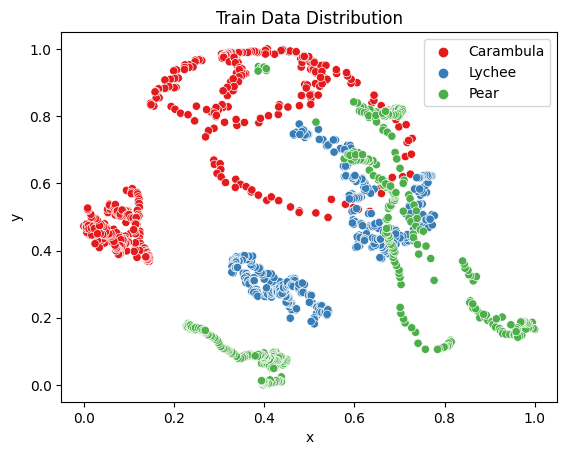

In [22]:
df = pd.DataFrame(train_x, columns=["x", "y"])
df["label"] = [ImageType(x).name for x in train_y]
sns.scatterplot(df, x="x", y="y", hue="label", palette="Set1")

plt.title("Train Data Distribution")
plt.legend()
plt.show()


# 2 Layer model

## Training

In [23]:
# Reset the random generator
rng = rng_generator()
pred_2layer = []

model_2layer = [
    NN(
        [
            Config.num_component.value,
            Config.size_2layer.value[i],
            len(ImageType),
        ],
        "ReLU",
    )
    for i in range(len(Config.size_2layer.value))
]

for model in model_2layer:
    model.train(
        train_x,
        train_y,
        learning_rate=Config.learning_rate_2layer.value,
        epoch=Config.epoch.value,
        batch_size=Config.batch_size.value,
    )

for model in model_2layer:
    pred_2layer.append(model.pred(test_x))


## Accuracy & Loss curve

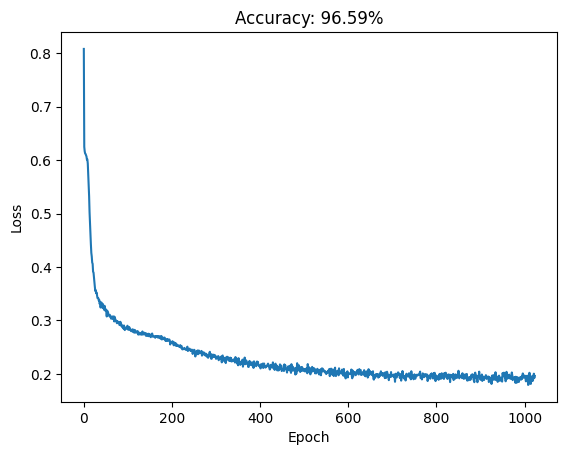

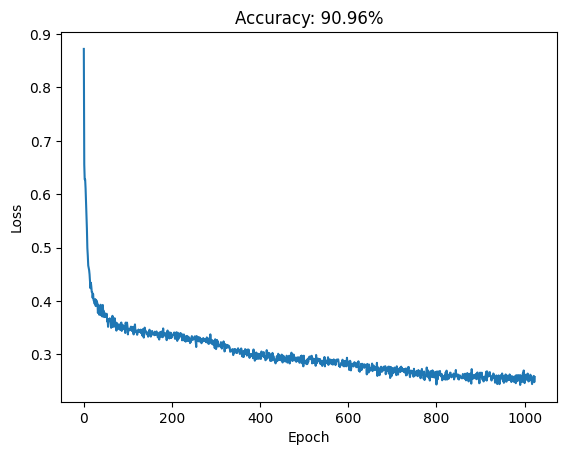

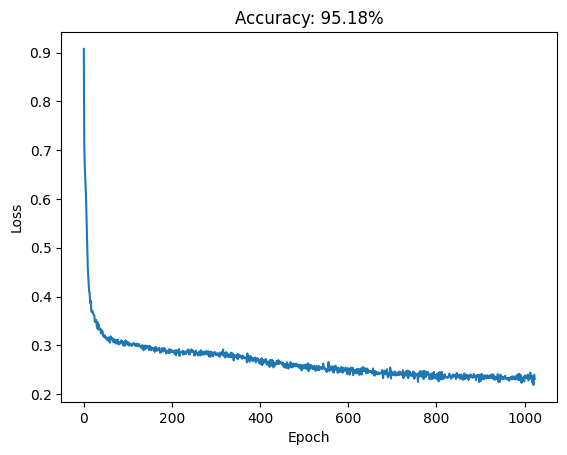

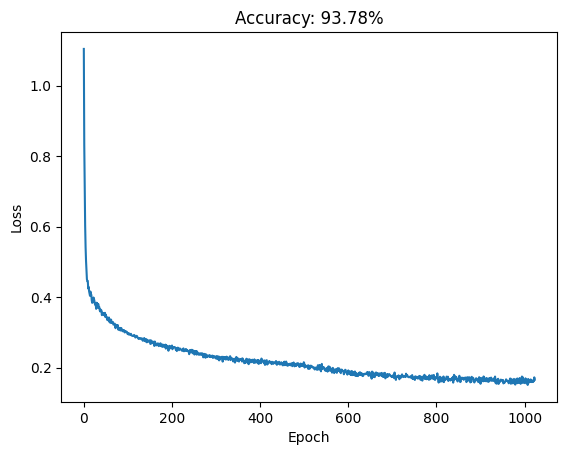

In [24]:
for pred, model in zip(pred_2layer, model_2layer):
    title = "Accuracy: {:.2f}%".format(evaluate(pred, test_y) * 100)

    plot_loss_curve(model.epoch_loss, title)


## Decision region

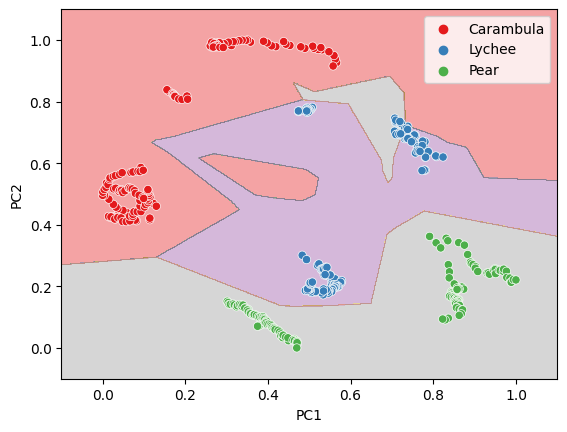

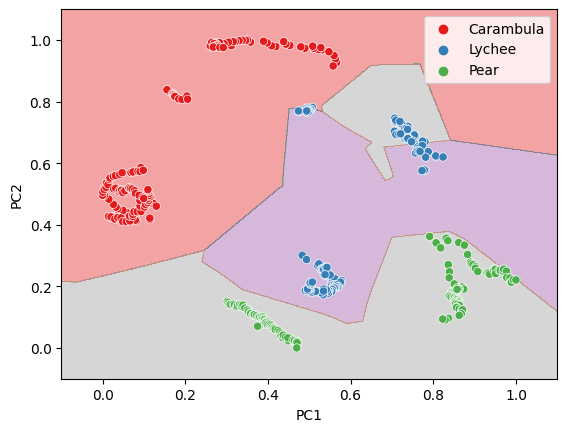

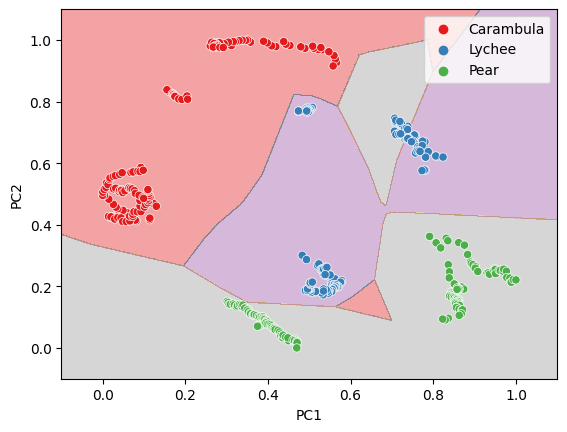

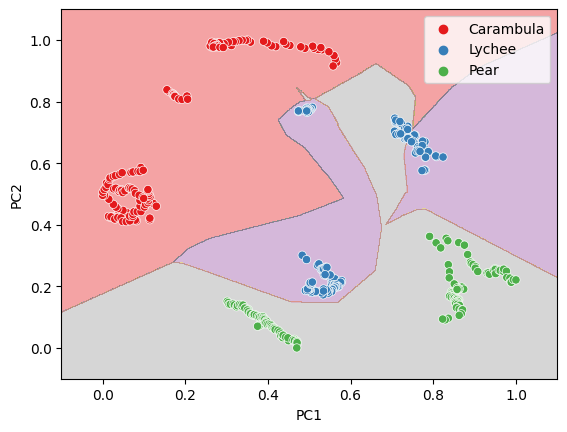

In [25]:
figs = [
    plot_decision_region(test_x, test_y, pred, model)
    for pred, model in zip(pred_2layer, model_2layer)
]

for fig in figs:
    fig.plot()


# 3 Layer model

## Training

In [26]:
# Reset the random generator
rng = rng_generator()
pred_3layer = []

model_3layer = [
    NN(
        [
            Config.num_component.value,
            Config.size_3layer.value[i][0],
            Config.size_3layer.value[i][1],
            len(ImageType),
        ],
        "ReLU",
    )
    for i in range(len(Config.size_3layer.value))
]

for model in model_3layer:
    model.train(
        train_x,
        train_y,
        learning_rate=Config.learning_rate_3layer.value,
        epoch=Config.epoch.value,
        batch_size=Config.batch_size.value,
    )

for model in model_3layer:
    pred_3layer.append(model.pred(test_x))


## Accuracy & Loss curve

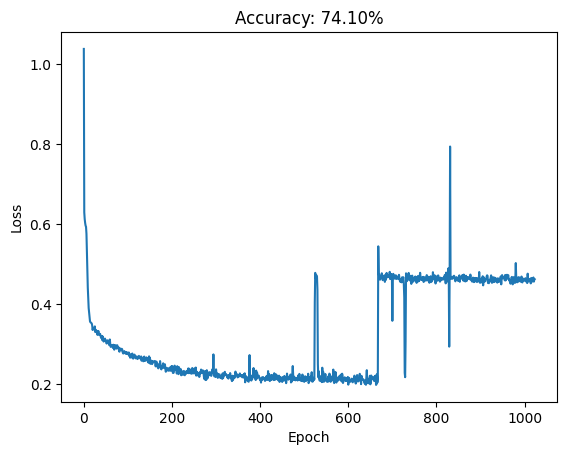

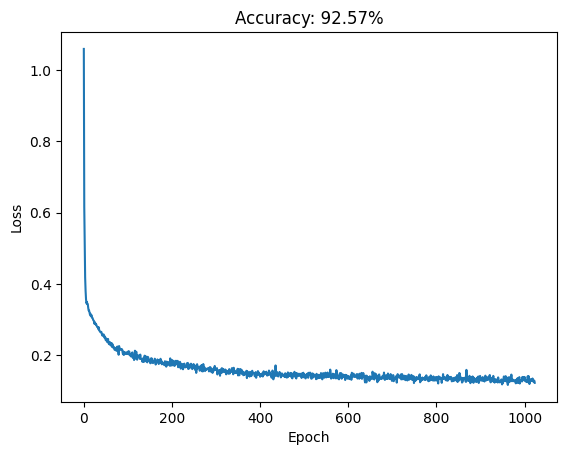

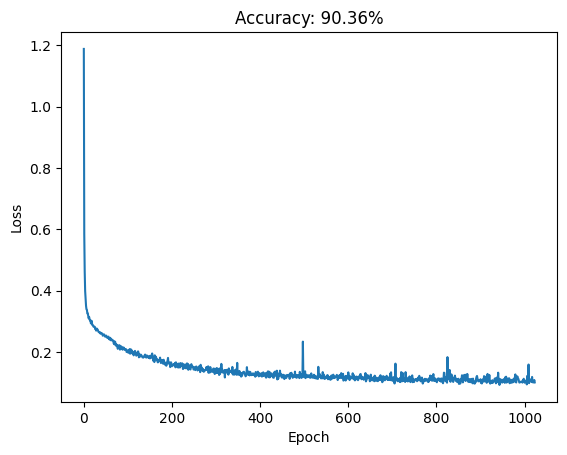

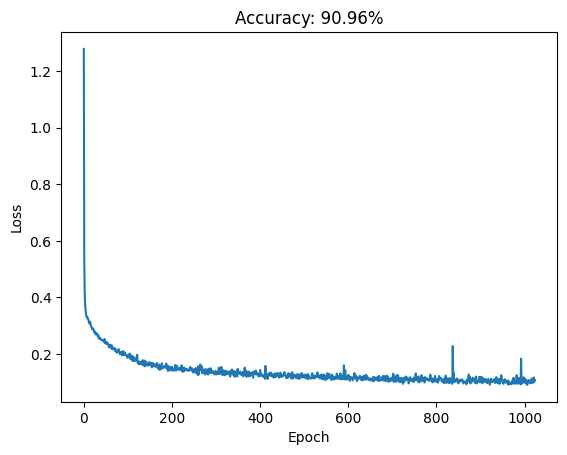

In [27]:
for pred, model in zip(pred_3layer, model_3layer):
    title = "Accuracy: {:.2f}%".format(evaluate(pred, test_y) * 100)

    plot_loss_curve(model.epoch_loss, title)


## Decision region

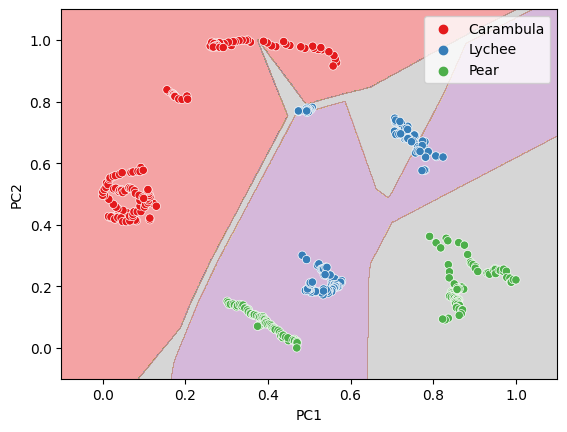

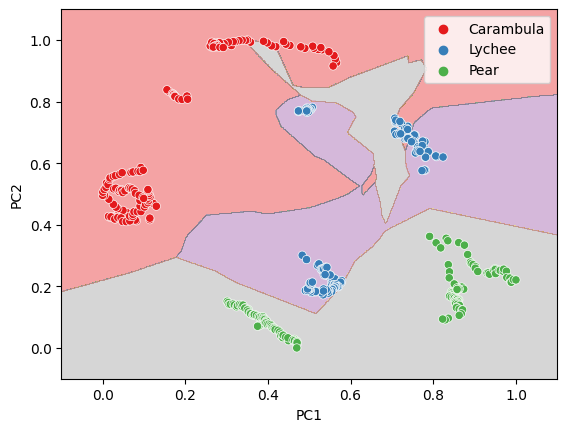

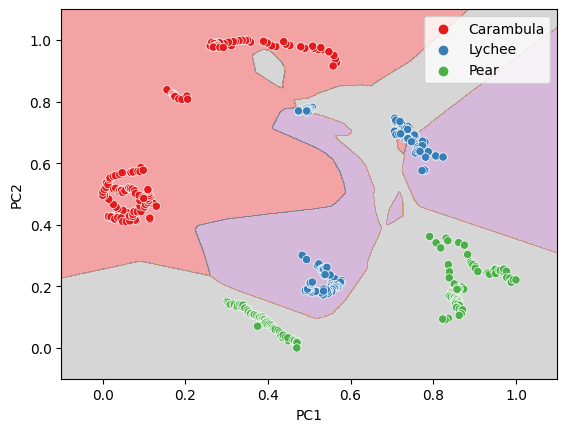

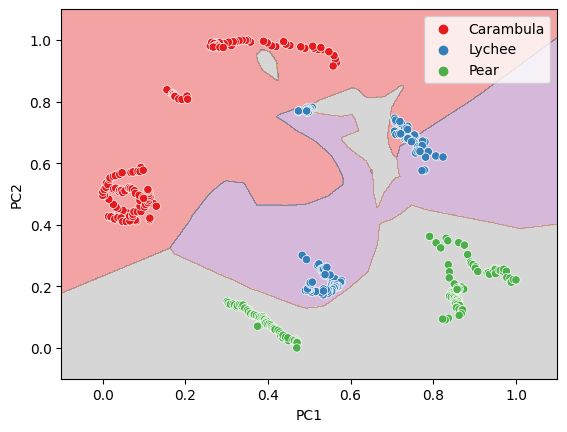

In [28]:
figs = [
    plot_decision_region(test_x, test_y, pred, model)
    for pred, model in zip(pred_3layer, model_3layer)
]

for fig in figs:
    fig.plot()
